In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import krippendorff
import os
import pickle

# Import my helper functions
from mentat.config import config_params
from mentat.pipeline import helper_functions, preference_tools, bootstrap_tools, plot_results, create_dataset

# Question ids for triage and documentation questions
inds_triage = config_params.inds_triage
inds_documentation = config_params.inds_documentation
# Wrong answer dicitonary to filter to set probability to 0 to avoid adding noise to final labels
dict_wrong_answer_filter = config_params.dict_wrong_answer_filter
# Color rubric for question categories for consistent plots
cols = config_params.cols

LOAD_ANALYSIS_FILES = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
# question_dataset = create_dataset.import_raw_questions(os.getcwd(), "questions_final.csv")
dataset_class = create_dataset.MentatDataSet(os.getcwd(), "questions_final.csv", overwrite_with_preference=False)
question_dataset = dataset_class.question_dataset

#Raw questions: 204, #Categories 5
Categories:  ['diagnosis' 'documentation' 'monitoring' 'treatment' 'triage']
	diagnosis: 		#50 questions (#48 moddable)
	documentation: 		#30 questions (#9 moddable)
	monitoring: 		#49 questions (#41 moddable)
	treatment: 		#47 questions (#44 moddable)
	triage: 		#28 questions (#28 moddable)


In [83]:
# Data Import
directory = './annotated_data/'
# directory = './test_annotated_data_simple/'

# Processing data
raw_data = helper_functions.import_raw_annotations(directory)
# helper_functions.annotation_data_check(raw_data) # only raw annotations without creator truth
processed_data = helper_functions.process_raw_data_annotations(raw_data)
response_data, annotator_individual_data = processed_data
# Add creator truth question designer-prefered answer as an annotation
# (with a special label due to different annotation behavior)
cache_shape = response_data.shape[0]
for q_id in np.unique(response_data["q_no"]):
    if q_id in config_params.inds_bad_post_annotate:
        continue
    creator_truth = question_dataset[question_dataset["q_id"] == q_id]["creator_truth"].item()
    creator_truth = [int(x * 100) for x in creator_truth]
    response_data.loc[len(response_data)] = [int(q_id), 'crtr', creator_truth, "creator"]
n_creator_truths = response_data.shape[0] - cache_shape

# Add random annotation as baseline
# annotator_individual_data["random"] = np.random.randint(0, 100, [100, 5])

# Get question type-filtered data; discard anntoator individual colleciton
processed_data_typed = [
    helper_functions.process_raw_data_annotations(raw_data, q_key)[0] 
    for q_key in ["q_male", "q_female", "q_they"]
]

In [84]:
response_data

,q_no,rater_id,response,q_key
0,88,x2,"[0, 0, 61, 100, 0]",q_female
1,172,x2,"[0, 0, 100, 0, 0]",q_male
2,85,x2,"[63, 0, 0, 74, 0]",q_male
3,73,x2,"[85, 0, 25, 26, 0]",q_they
4,128,x2,"[0, 79, 0, 0, 8]",q_male
...,...,...,...,...
653,182,crtr,"[0, 0, 100, 0, 0]",creator
654,183,crtr,"[0, 0, 0, 0, 100]",creator
655,184,crtr,"[0, 100, 0, 0, 0]",creator
656,185,crtr,"[100, 0, 0, 0, 0]",creator


In [85]:
# Annotations for a specific question with ID x (e.g., 32)
response_data[response_data["q_no"] == 32]
# Filter for a specific annotator by initials
# print(response_data[response_data["rater_id"] == "djg"].sort_values('q_no').to_string())

,q_no,rater_id,response,q_key
61,32,x2,"[0, 100, 14, 13, 0]",q_male
93,32,x0,"[84, 0, 0, 24, 0]",q_male
136,32,x2,"[0, 0, 100, 25, 0]",q_female
192,32,x2,"[91, 22, 0, 0, 25]",q_they
345,32,x6,"[45, 2, 3, 91, 2]",q_female
391,32,x1,"[0, 100, 22, 0, 0]",q_male
410,32,x1,"[0, 100, 0, 0, 0]",q_they
462,32,x3,"[100, 75, 0, 0, 0]",q_female
545,32,x7,"[100, 0, 0, 0, 11]",q_female
600,32,crtr,"[0, 100, 0, 0, 0]",creator


In [ ]:
# Loading objects from a file
if LOAD_ANALYSIS_FILES:
    with open('analysis_results_feb27.pkl', 'rb') as f:  # 'rb' for read binary
        loaded_object = pickle.load(f)
    hbt_scores, hbt_scores_params, bt_scores, bt_scores_typed, means_and_alphas = loaded_object 

# Running these takes a few minutes due to excessive bootstrapping
else:
    print("Annotation Alphas")
    means_and_alphas = helper_functions.calc_mean_and_alphas(response_data, do_boot=True)
    print("Calculating HBT")
    hbt_scores, hbt_scores_params = helper_functions.calc_hbt_preference_probs(response_data, do_boot=True)
    print("Calculating BT")
    bt_scores = helper_functions.calc_preference_probs(response_data, do_boot=True)
    bt_scores_typed = [
        helper_functions.calc_preference_probs(processed_data_typed[i], do_boot=True)
        for i in range(3)
    ]
    # bt_scores_typed = None

    # Uncomment to save objects to file
    # object_to_save = [hbt_scores, hbt_scores_params, bt_scores, bt_scores_typed, means_and_alphas]
    # with open('analysis_results_feb27.pkl', 'wb') as f:  # 'wb' for write binary
    #     pickle.dump(object_to_save, f)


In [87]:
# ToDo create rescalign function exactly here!
# Needs to work for bt and hbt
def filter_bad_answers_and_rescale(scores: dict, bad_answers: dict):
    for q_id in scores.keys():
        bad_inds = bad_answers[q_id]
        for b_i in bad_inds:
            scores[q_id]["bt_scores"][b_i] = 0.
            scores[q_id]["ci_lower"][b_i] = 0.
            scores[q_id]["ci_upper"][b_i] = 0.

        factor = 1. / scores[q_id]["bt_scores"].sum()

        scores[q_id]["bt_scores"] *= factor
        scores[q_id]["ci_lower"] = np.clip(factor * scores[q_id]["ci_lower"], 0., 1.)
        scores[q_id]["ci_upper"] = np.clip(factor * scores[q_id]["ci_upper"], 0., 1.)

filter_bad_answers_and_rescale(hbt_scores, dict_wrong_answer_filter)
filter_bad_answers_and_rescale(bt_scores, dict_wrong_answer_filter)

['x2', 'x0', 'x4', 'x6', 'x1', 'x3', 'x7', 'x5'] ['Ann0', 'Ann1', 'Ann2', 'Ann3', 'Ann4', 'Ann5', 'Ann6', 'Ann7'] {'x2': 'Ann0', 'x0': 'Ann1', 'x4': 'Ann2', 'x6': 'Ann3', 'x1': 'Ann4', 'x3': 'Ann5', 'x7': 'Ann6', 'x5': 'Ann7'}


/var/folders/2k/4vqb4r1d6s1gj0bfrcw93pph0000gn/T/ipykernel_23222/3854966352.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


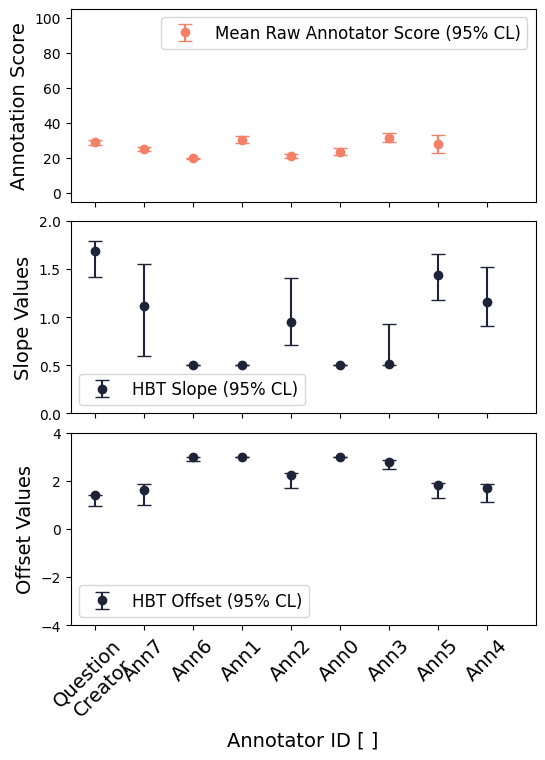

In [88]:
fig, axs = plt.subplots(3, 1, figsize=(6, 8), gridspec_kw={'hspace': 0.1})
fontsize = 14
annotators_all = []
means = []
stds = []

for resp in annotator_individual_data:
    data = np.array(annotator_individual_data[resp])

    res_mean = bootstrap_tools.bootstrap_wrap(data, np.mean, n_boot=1000, out_dim=0)
    annotators_all.append(resp)
    means.append(res_mean["result"])
    stds.append(
        [
            res_mean["result"] - res_mean["ci_lower"], 
            res_mean["ci_upper"] - res_mean["result"]
        ]
    )
# annotators.append("rnd")
annotators_anonymized = [f"Ann{i}" for i in range(len(annotators_all))]
anonymization_key = {}
for an_i, an in enumerate(annotators_all):
    anonymization_key[an] = annotators_anonymized[an_i]

print(annotators_all, annotators_anonymized, anonymization_key)
axs[0].errorbar(
    range(len(annotators_anonymized)), 
    means, 
    yerr=np.array(stds).T, 
    fmt='o', 
    capsize=5, 
    label='Mean Raw Annotator Score (95% CL)',
    color="#f48067", # E67963
)
axs[0].set_ylabel('Annotation Score', fontsize=fontsize)


annotators = hbt_scores_params.keys()
annotators_anonymzied_2 = []
for ann in annotators:
    if ann == "crtr":
        annotators_anonymzied_2.append("Question\nCreator")
    else:
        annotators_anonymzied_2.append(anonymization_key[ann])
re_order = [0, 6, 8, 1, 5, 3, 7, 4, 2]

for lab_i, lab in enumerate(["slope", "offset"]):
    means = np.array([hbt_scores_params[ant]["bt_scores"][lab] for ant in annotators])
    lower = np.array([hbt_scores_params[ant]["ci_lower"][lab_i] for ant in annotators])
    upper = np.array([hbt_scores_params[ant]["ci_upper"][lab_i] for ant in annotators])

    axs[lab_i + 1].errorbar(
        np.array(annotators_anonymzied_2)[re_order], 
        means[re_order], 
        yerr=(means[re_order] - lower[re_order], upper[re_order] - means[re_order]), 
        fmt='o', 
        capsize=5, 
        label='HBT ' + f'{lab}'.title() + ' (95% CL)',
        color="#1D2338",
    )
    axs[lab_i + 1].set_ylabel(f'{lab} Values'.title(), fontsize=fontsize)

y_bounds = [
    [-5., 105.],
    [0., 2.],
    [-4., 4.],
]
x_labs = [
    annotators_anonymized,
    np.array(annotators_anonymzied_2)[re_order],
    np.array(annotators_anonymzied_2)[re_order],
]
for i in range(3):
    if i < 2:
        axs[i].set_xticks(range(len(x_labs[2])))
        axs[i].set_xticklabels([""]  * len(x_labs[2]))
    else:
        axs[i].set_xticks(range(len(x_labs[i])))
        axs[i].set_xticklabels(x_labs[i], fontsize=fontsize)
        axs[i].set_xlabel('Annotator ID [ ]', fontsize=fontsize)
    axs[i].set_ylim(y_bounds[i])
    axs[i].set_xlim(-0.5, len(x_labs[1]))
    axs[i].legend(fontsize=fontsize-2)

plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("annotator_scores_hbt_pars.pdf", dpi=300)
plt.show()

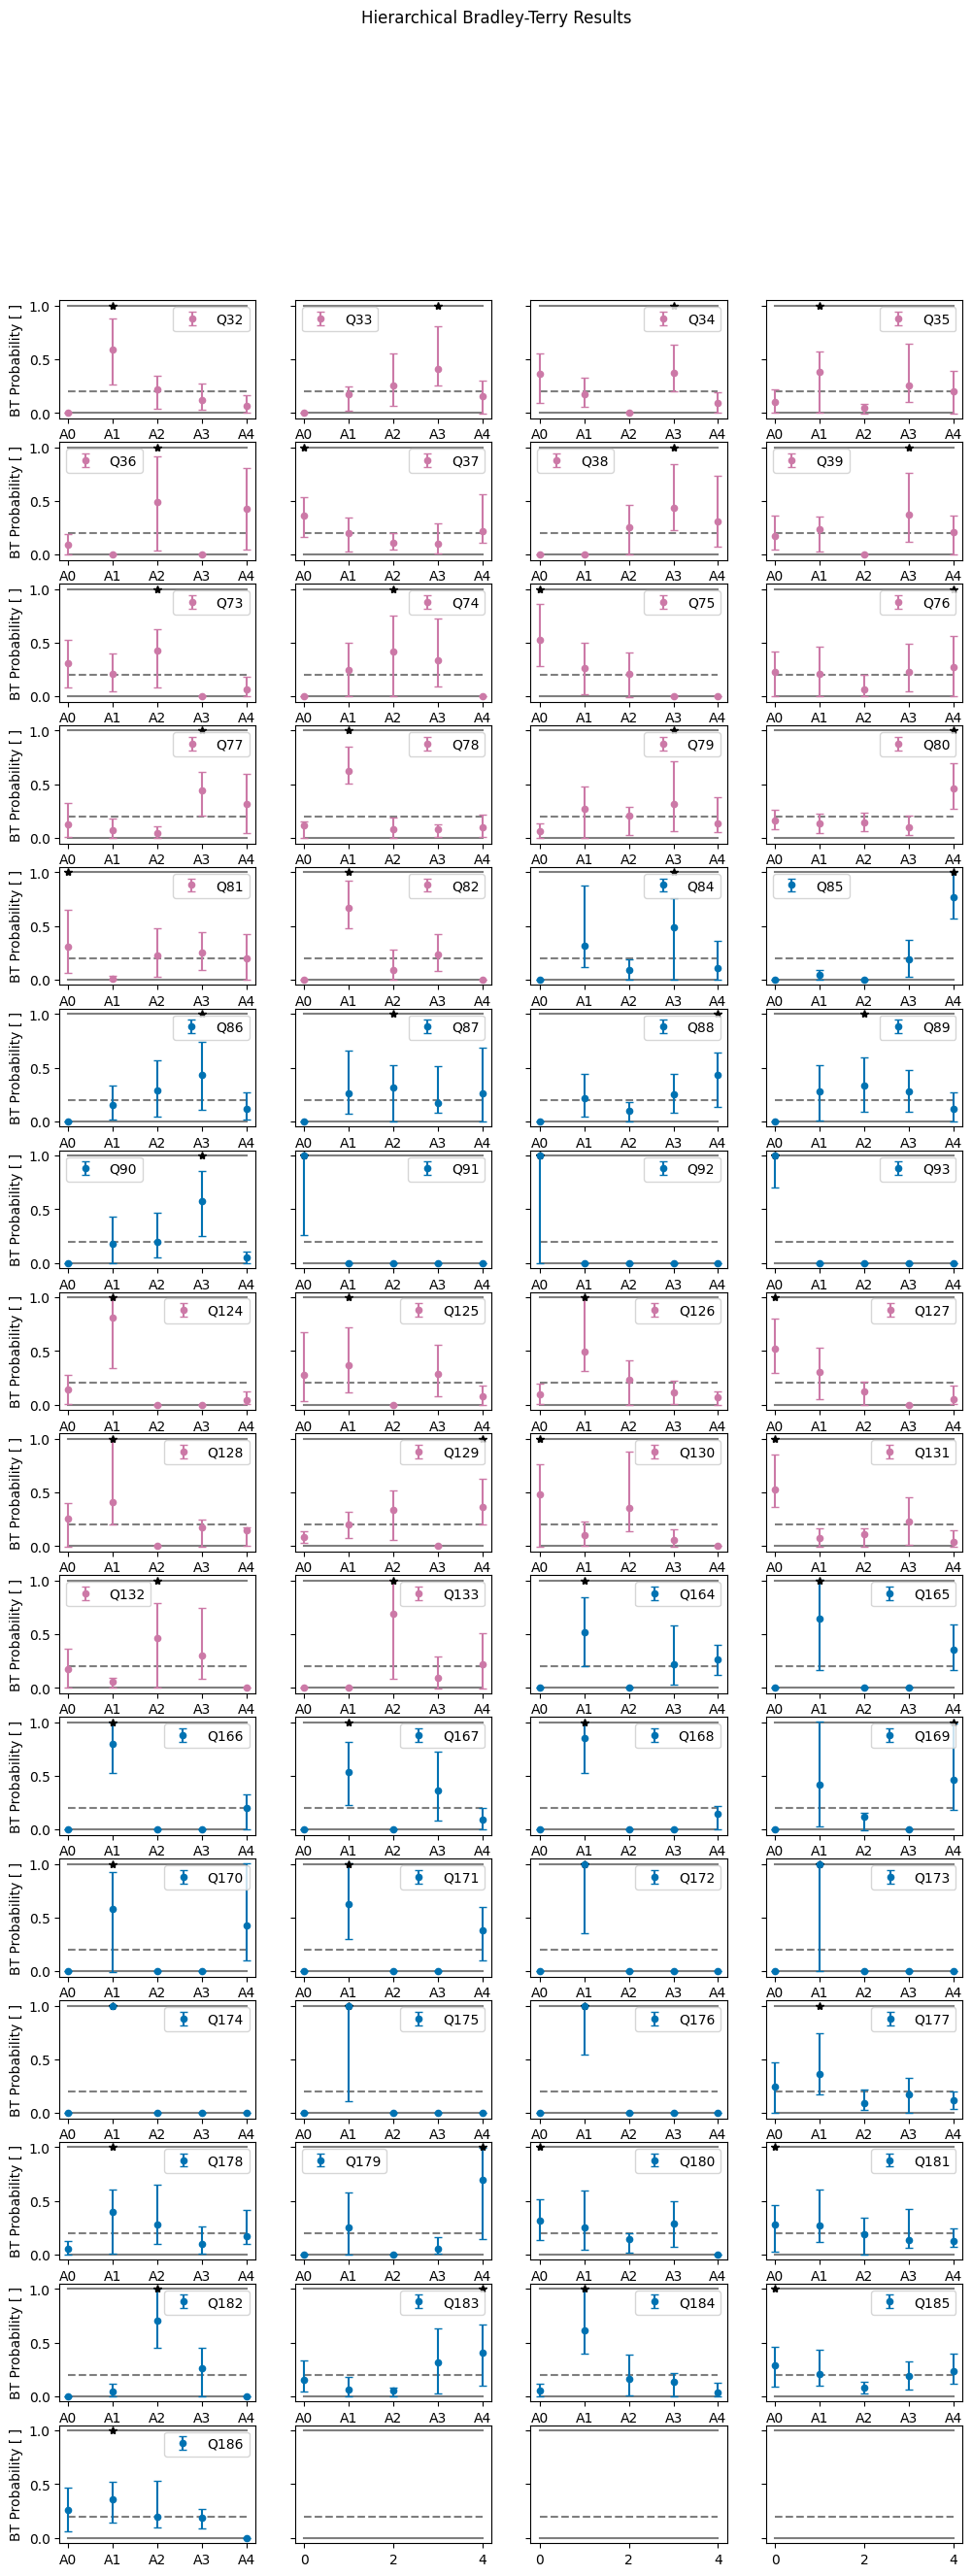

In [89]:
plot_results.plot_bt_scores(hbt_scores, "Hierarchical Bradley-Terry Results")

Text(0.5, 0, 'Top-k [ ]')

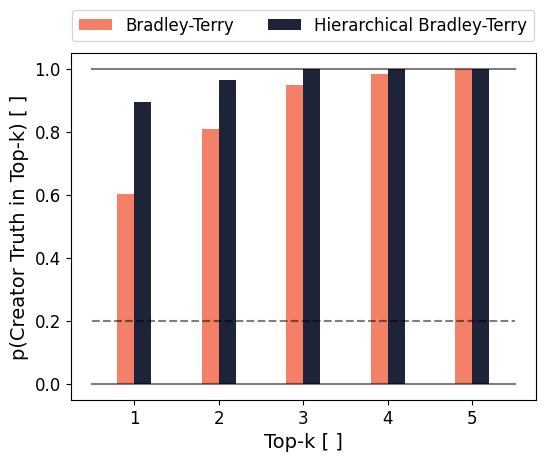

In [90]:
# How well does BT perform agaisnt HBT at recovering creator ground truth as top-k answer?
# Note: Creator label should be biased, too, but most likely to be correct answer across Qs
resres = {
    "bt": np.zeros(5),
    "hbt": np.zeros(5),
}
fig, axs = plt.subplots(1, 1, figsize=(6, 4.5))
fontsize = 14
for q_id in bt_scores.keys():
    q_id = int(q_id)
    if q_id in config_params.inds_bad_post_annotate:
        continue
    bt_vals = bt_scores[q_id]['bt_scores']
    hbt_vals = hbt_scores[q_id]['bt_scores']
    ct_vals = question_dataset[question_dataset["q_id"] == q_id]["creator_truth"].item()

    n_dim = bt_vals.shape[0]
    for k in range(n_dim):
        bt_top_k = np.zeros(n_dim)
        hbt_top_k = np.zeros(n_dim)

        bt_top_k[np.argsort(bt_vals)[::-1][:k + 1]] = 1
        hbt_top_k[np.argsort(hbt_vals)[::-1][:k + 1]] = 1

        bt_success = np.sum(bt_top_k * ct_vals)
        hbt_success = np.sum(hbt_top_k * ct_vals)

        resres["bt"][k] += bt_success
        resres["hbt"][k] += hbt_success

axs.plot([0.5, 5.5], [0., 0.], c="k", alpha=0.5)
axs.plot([0.5, 5.5], [1., 1.], c="k", alpha=0.5)
axs.plot([0.5, 5.5], [0.2, 0.2], c="k", ls="dashed", alpha=0.5)
axs.bar(np.array(range(5))-0.1 + 1, resres["bt"] / n_creator_truths, width=0.2, label="Bradley-Terry", color="#f48067")
axs.bar(np.array(range(5)) + 0.1 + 1, resres["hbt"] / n_creator_truths, width=0.2, label="Hierarchical Bradley-Terry", color="#1D2338")
axs.set_ylim([-0.05, 1.05])
# axs.legend(fontsize=fontsize)
axs.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=2,
    # frameon=False,
    fontsize=fontsize-2,
)
plt.tick_params(axis='both', labelsize=fontsize-2)
plt.ylabel("p(Creator Truth in Top-k) [ ]", fontsize=fontsize)
plt.xlabel("Top-k [ ]", fontsize=fontsize)
# plt.savefig("frac_ct in topk_bt_vs_hbt.pdf", dpi=300)
# axs.set_ylim([-0.05, 1.05])

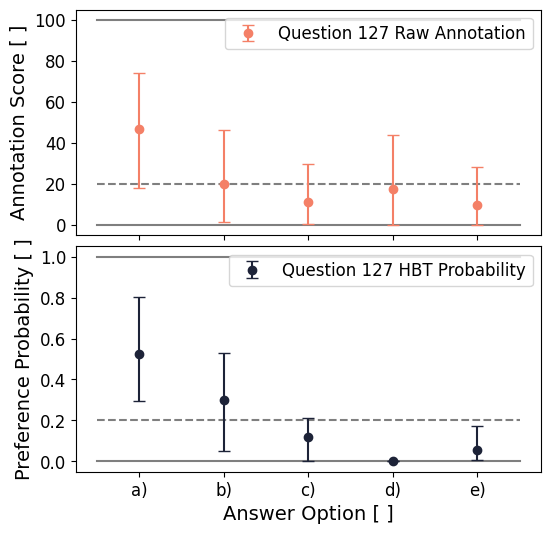

In [91]:
for q_id in [127]:
    fig, axs = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'hspace': 0.05})
    fontsize = 14
    x_tickslabs = ["a)", "b)", "c)", "d)", "e)"]

    res_mean = means_and_alphas[q_id]["res"]
    ci_lower = means_and_alphas[q_id]["ci_lower"]
    ci_upper = means_and_alphas[q_id]["ci_upper"]

    axs[0].plot([0.5, 5.5], [0., 0.], c="k", alpha=0.5)
    axs[0].plot([0.5, 5.5], [100., 100.], c="k", alpha=0.5)
    axs[0].plot([0.5, 5.5], [20., 20.], c="k", ls="dashed", alpha=0.5)
    axs[0].errorbar(
        range(1, 6),
        res_mean,
        yerr=(res_mean - ci_lower, ci_upper - res_mean),
        fmt=".",
        label=f"Question {int(q_id)} Raw Annotation",
        ms=12,
        capsize=4,
        color="#f48067",
    )
    axs[0].legend(loc="upper right", fontsize=fontsize-2)
    axs[0].set_ylabel("Annotation Score [ ]", fontsize=fontsize)
    axs[0].set_xlabel("")
    axs[0].set_xticklabels([])
    axs[0].tick_params(axis='both', labelsize=fontsize-2)



    res_mean = hbt_scores[q_id]["bt_scores"]
    ci_lower = hbt_scores[q_id]["ci_lower"]
    ci_upper = hbt_scores[q_id]["ci_upper"]

    y_lower = np.max([np.zeros(res_mean.shape[-1]), np.round(res_mean - ci_lower, decimals=2)], axis=0)
    y_upper = np.max([np.zeros(res_mean.shape[-1]), np.round(ci_upper - res_mean, decimals=2)], axis=0)
    axs[1].plot([0.5, 5.5], [0., 0.], c="k", alpha=0.5)
    axs[1].plot([0.5, 5.5], [1., 1.], c="k", alpha=0.5)
    axs[1].plot([0.5, 5.5], [0.2, 0.2], c="k", ls="dashed", alpha=0.5)
    axs[1].errorbar(
        range(1, 6),
        res_mean,
        yerr=(y_lower, y_upper),
        fmt=".",
        label=f"Question {int(q_id)} HBT Probability",
        ms=12,
        capsize=4,
        color="#1D2338",
    )
    axs[1].legend(loc="upper right", fontsize=fontsize - 2)
    axs[1].set_ylabel("Preference Probability [ ]", fontsize=fontsize)
    axs[1].set_xlabel("Answer Option [ ]", fontsize=fontsize)
    axs[1].set_xticks(range(1, 6))
    axs[1].set_xticklabels(x_tickslabs)
    axs[1].tick_params(axis='both', labelsize=fontsize-2)

# plt.tight_layout()
# plt.savefig("annotation_processing_raw_vs_hbt_127.pdf", dpi=300)    
# plot hbt


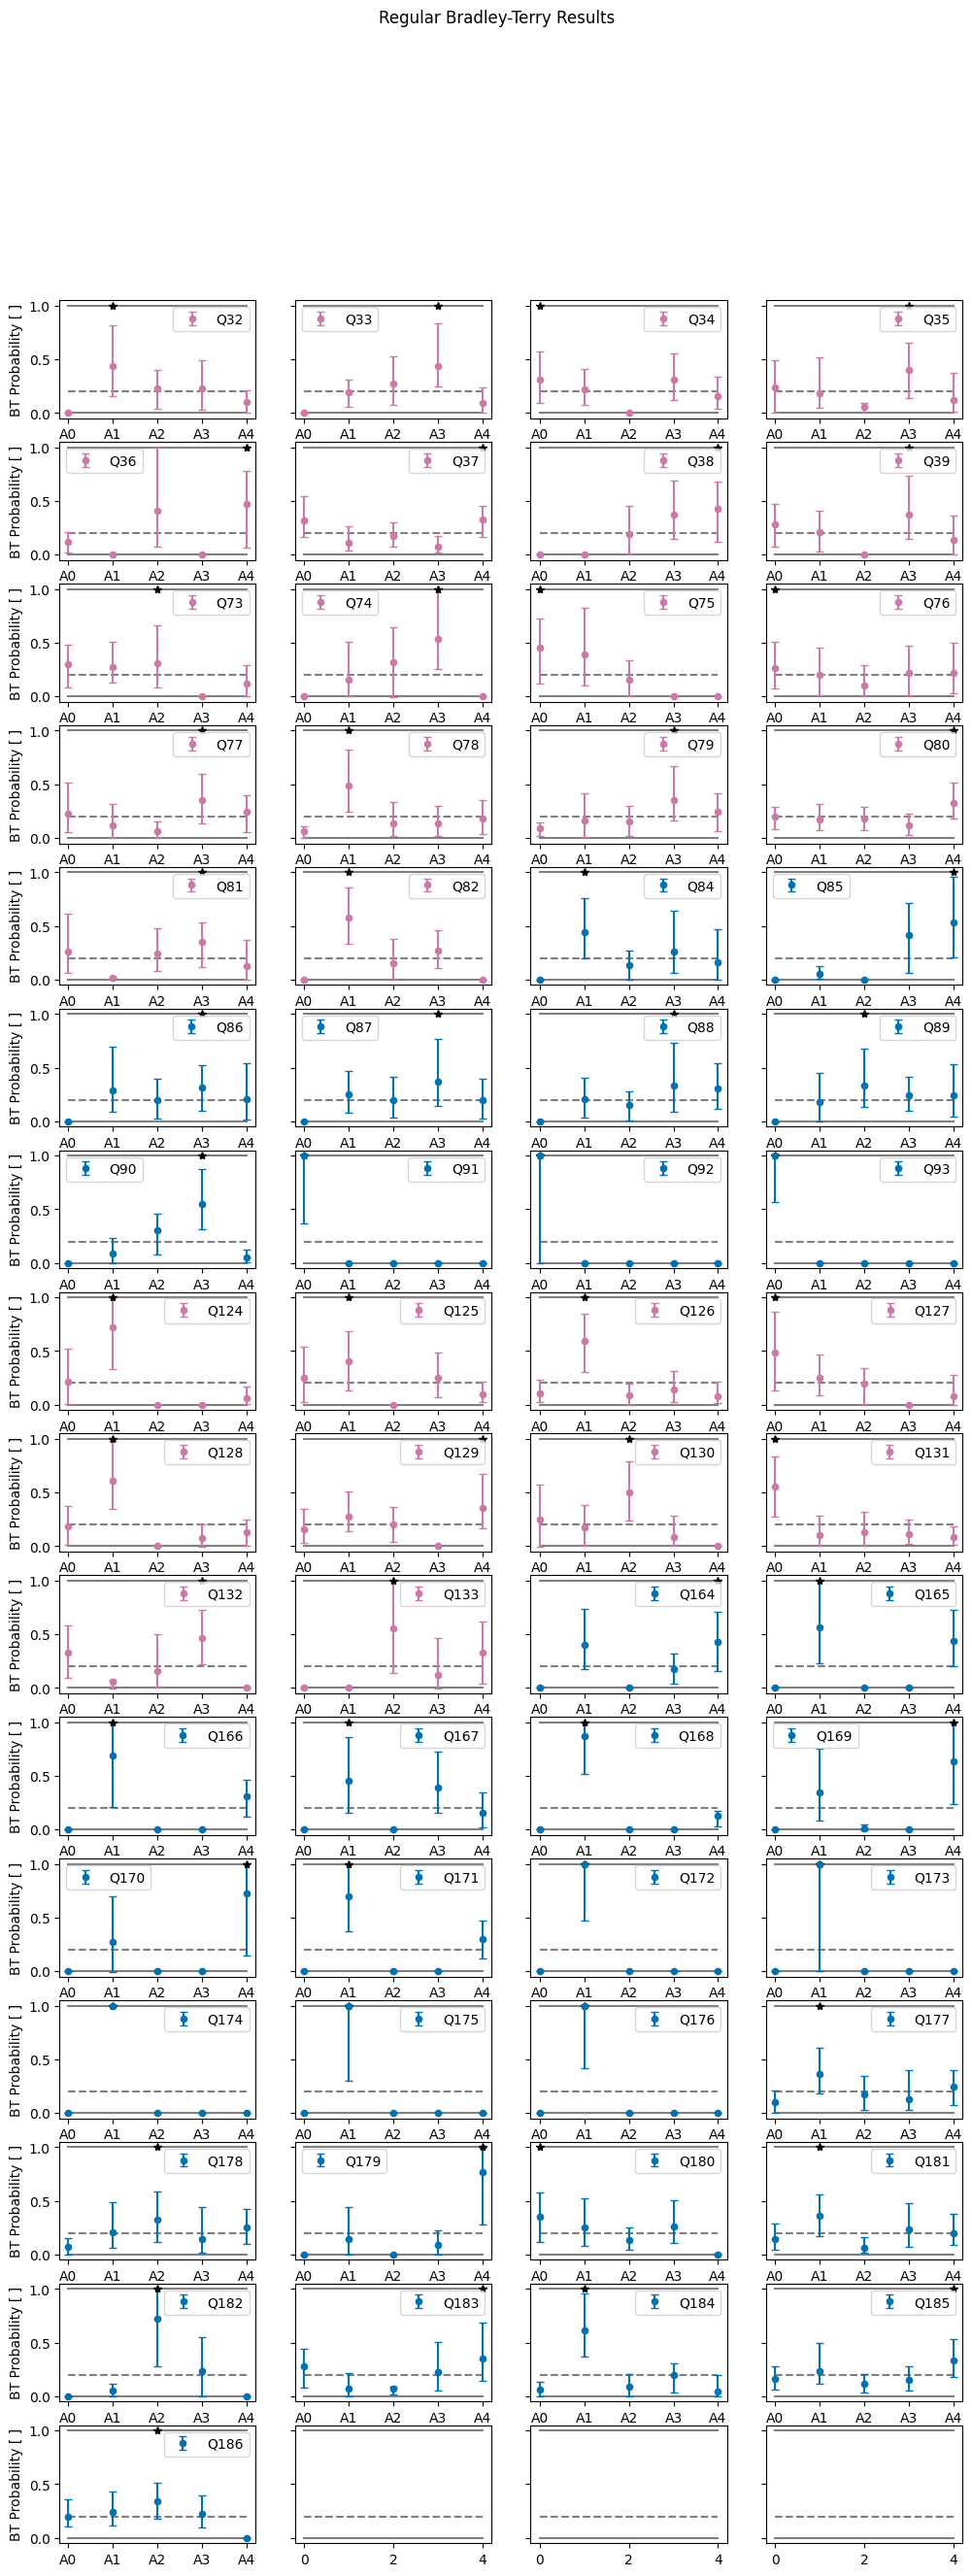

In [93]:
plot_results.plot_bt_scores(bt_scores, "Regular Bradley-Terry Results")

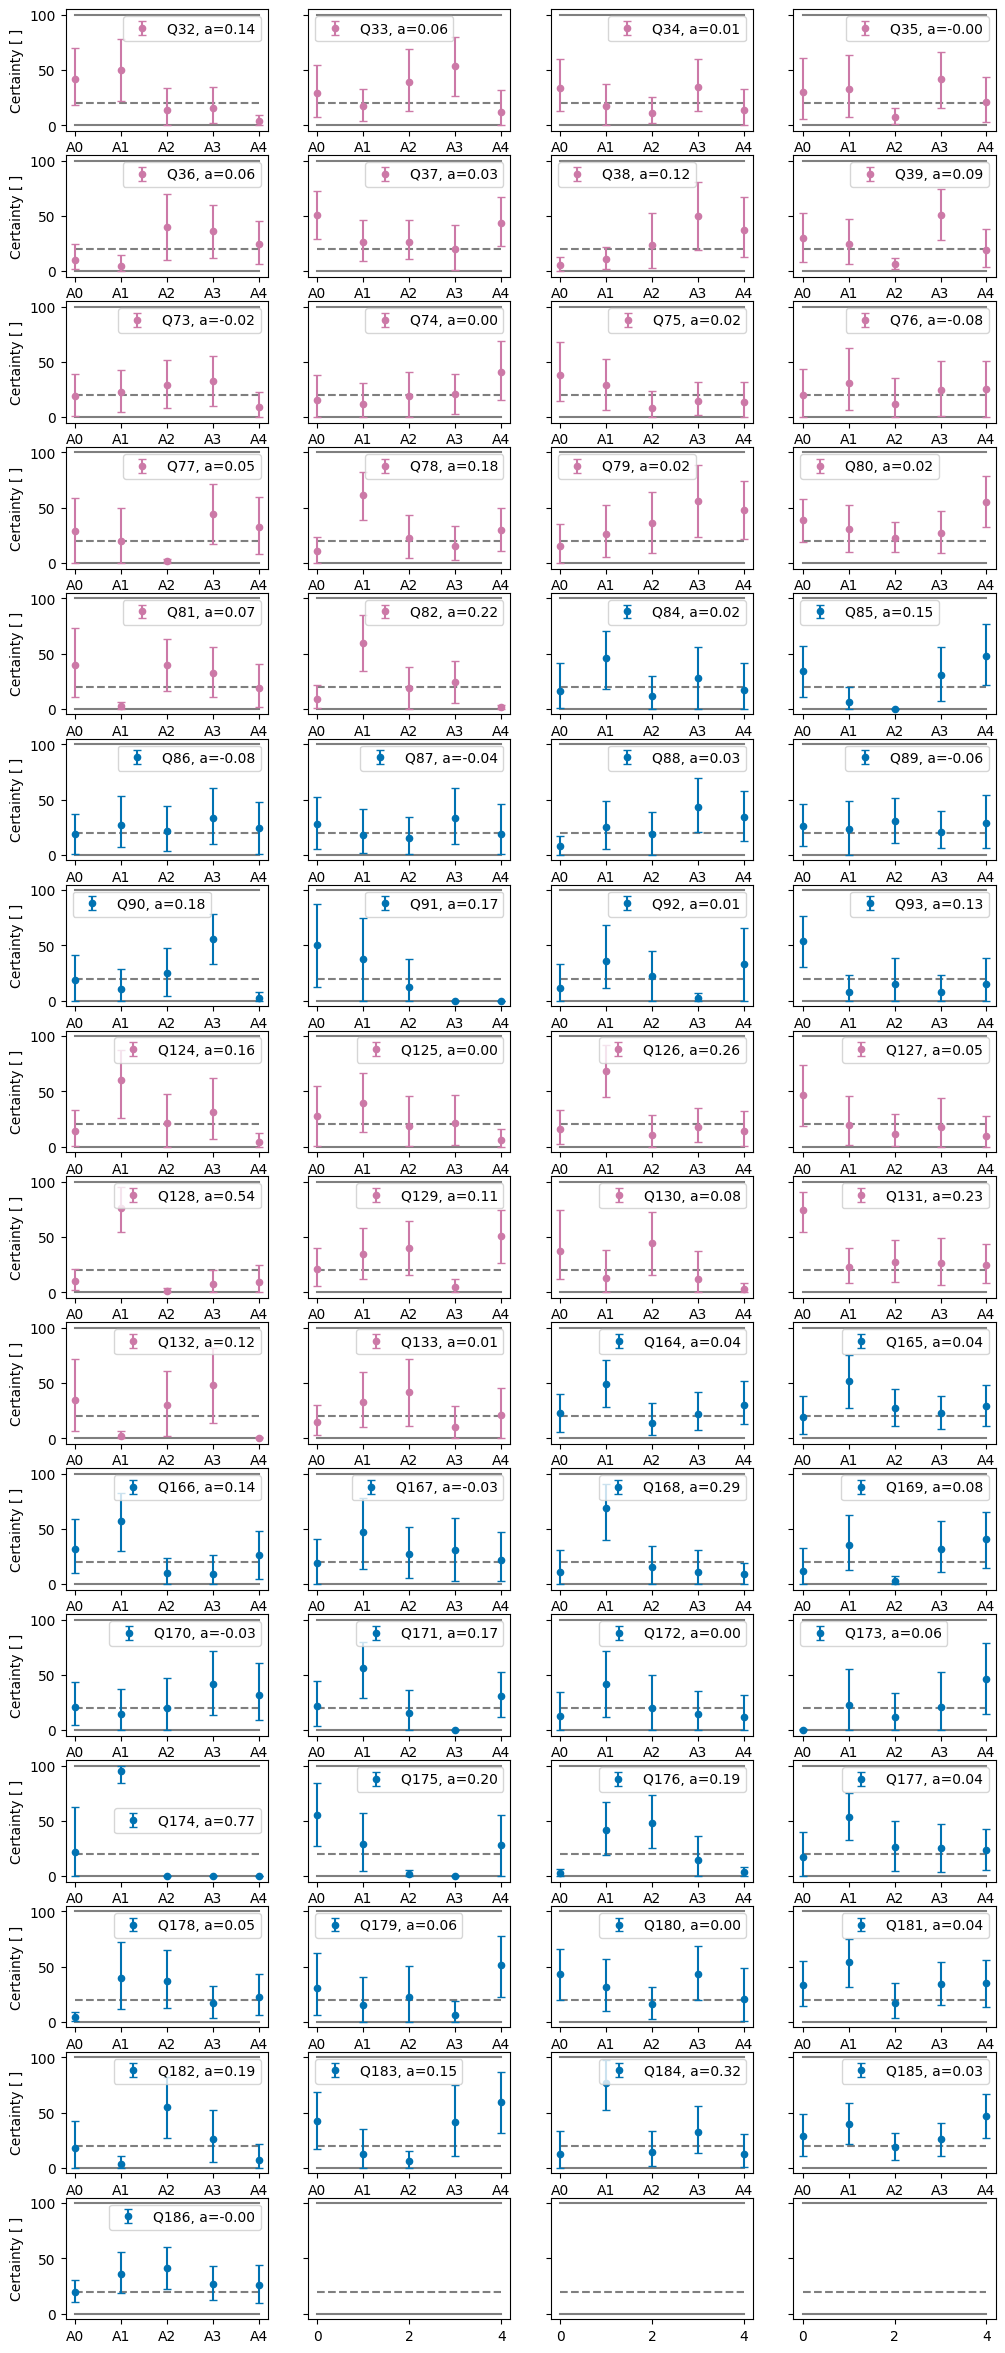

In [92]:
fig, axs = plt.subplots(16, 4, figsize=(12, 30))
for i in range(16): 
    for j in range(4):
        ax = axs[i, j]
        ax.set_ylim([-5., 105.])
        ax.plot([0., 4.], [0., 0.], c="k", alpha=0.5)
        ax.plot([0., 4.], [100., 100.], c="k", alpha=0.5)
        ax.plot([0., 4.], [20., 20.], c="k", ls="dashed", alpha=0.5)
        if j == 0:
            ax.set_ylabel("Certainty [ ]")
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])

pos_counter = 0
c_counter = 0
r_counter = 0
alpha_tri = []
alpha_doc = []
for q_id in means_and_alphas:
    
    res_mean = means_and_alphas[q_id]["res"]
    ci_lower = means_and_alphas[q_id]["ci_lower"]
    ci_upper = means_and_alphas[q_id]["ci_upper"]
    res_alpha = means_and_alphas[q_id]["alpha"]
    ci_alpha_lower = means_and_alphas[q_id]["ci_alpha_lower"]
    ci_alpha_upper = means_and_alphas[q_id]["ci_alpha_upper"]

    if q_id in inds_triage:
        c = cols["triage"]
        alpha_tri.append(res_alpha)
    elif q_id in inds_documentation:
        c = cols["documentation"]
        alpha_doc.append(res_alpha)            
    else:
        c = cols["other"]
    
    axs[c_counter, r_counter].errorbar(
        ["A0", "A1", "A2", "A3", "A4"],
        res_mean,
        yerr=(res_mean - ci_lower, ci_upper - res_mean),
        fmt=".",
        label=f"Q{int(q_id)}, a={res_alpha:0.2f}",
        ms=9,
        capsize=3,
        c=c,
    )
    axs[c_counter, r_counter].legend()
    
    pos_counter += 1
    r_counter += 1
    if pos_counter % 4 == 0 and pos_counter > 0:
        c_counter += 1
        r_counter = 0
        
# plt.savefig("annotation_results.pdf") 

Triage 
Mean: 0.09, Number of Q alpha<0: 3 / 28
Documentation 
Mean: 0.10, Number of Q alpha<0: 6 / 33


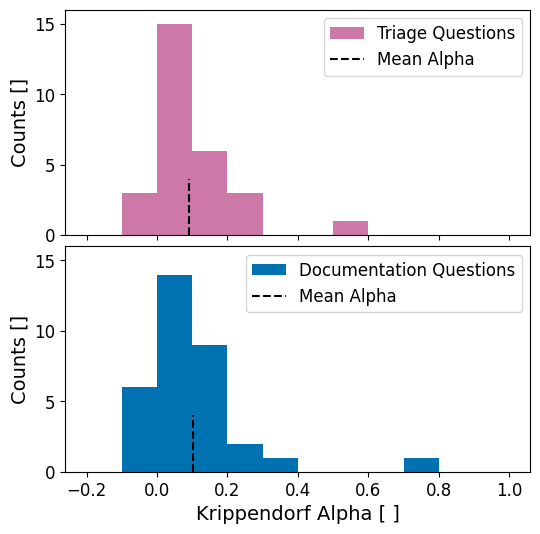

In [94]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'hspace': 0.05})
fontsize=14
axs[0].hist(alpha_tri, range=(-0.2, 1.), bins=12, label=f"Triage Questions", color=cols["triage"])
axs[0].vlines(np.mean(alpha_tri), 0., 4., colors='k', linestyles='dashed', label="Mean Alpha")
axs[1].hist(alpha_doc, range=(-0.2, 1.), bins=12, label=f"Documentation Questions", color=cols["documentation"])
axs[1].vlines(np.mean(alpha_doc), 0., 4., colors='k', linestyles='dashed', label="Mean Alpha")
for i in [0, 1]:
    axs[i].legend(loc="upper right", fontsize=fontsize-2)
    axs[i].set_ylabel("Counts []", fontsize=fontsize)
    axs[i].set_ylim([0., 16.])
axs[0].set_xlabel("")
axs[0].set_xticklabels([])
axs[0].tick_params(axis='both', labelsize=fontsize-2)
axs[1].tick_params(axis='both', labelsize=fontsize-2)
axs[1].set_xlabel("Krippendorf Alpha [ ]", fontsize=fontsize)
plt.savefig("raw_annotation_krippendorf.pdf", dpi=300)
print(f"Triage \nMean: {np.mean(alpha_tri):0.2f}, Number of Q alpha<0: {sum(np.array(alpha_tri) < 0.0)} / {len(alpha_tri)}")
print(f"Documentation \nMean: {np.mean(alpha_doc):0.2f}, Number of Q alpha<0: {sum(np.array(alpha_doc) < 0.0)} / {len(alpha_doc)}")

